In [2]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

# Visualizing Masked Self-Attention


In [33]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np
import os

from src.layers.attention import scaled_dot_product_attention
from presentation.pipelines.steps.load_data import build_loader
from presentation.pipelines.steps.model_design import load_pt_model
from src.models.astromer_0 import positional_encoding

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
model_path = './presentation/results/paper/2024-07-09_02-27-29/pretraining'
astromer, config = load_pt_model(model_path)

loaders = build_loader('./data/records/alcock/fold_0/alcock_20/', 
                       params=config,
                       batch_size=5, 
                       sampling=True,
                       probed=0.5)

[INFO] Zero architecture loaded
[INFO] Using masked-att with alpha = 1.00
[INFO] Using masked-att with alpha = 1.00
[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens
[INFO] Changing path:  ./data/records/alcock/fold_0/alcock_20/val
[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Normalization:  zero-mean
[INFO] Sampling random windows
[INFO] Zero
[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Normalization:  zero-mean
[INFO] Sampling random windows
[INFO] Zero


In [61]:
encoder = astromer.get_layer('encoder')

for batch, _ in loaders['train'].take(1):

    if config['arch'] == 'base':
        x, _ = encoder.input_format(batch)
        x = encoder.dropout_layer(x, training=False)

    if config['arch'] == 'zero':
        x_pe = positional_encoding(batch['times'], config['num_heads']*config['head_dim'], mjd=True)
        x_transformed = encoder.inp_transform(batch['input'])
        transformed_input = x_transformed + x_pe
        x = encoder.dropout(transformed_input, training=False)

    Q = encoder.enc_layers[-1].mha.wq(x)
    Q = encoder.enc_layers[-1].mha.split_heads(Q, batch_size=5)

    K = encoder.enc_layers[-1].mha.wk(x)
    K = encoder.enc_layers[-1].mha.split_heads(K, batch_size=5)

    V = encoder.enc_layers[-1].mha.wv(x)
    V = encoder.enc_layers[-1].mha.split_heads(V, batch_size=5)

    mask = batch['mask_in']

[INFO] Using PE with c: 2.0


### Effect of temperature

In [62]:
w = []
temps = np.linspace(0.25, 1., 5)
for t in temps:
    scaled_attention, attention_weights, qk_values = scaled_dot_product_attention(Q, 
                                                                                  K, 
                                                                                  V, 
                                                                                  mask=tf.ones_like(mask), 
                                                                                  m_alpha=-1e9, 
                                                                                  mask_format='K',
                                                                                  temperature=t)
    
    w.append(attention_weights)

In [63]:
master = w[-1][0, 0, :, 0]

attention_vectors = []
for ww in w:
    master = ww[0, 0, :, 0]
    attention_vectors.append(master)

Text(0, 0.5, '$s(\\rm{QK}^{\\top} -\\infty\\rm{M})$')

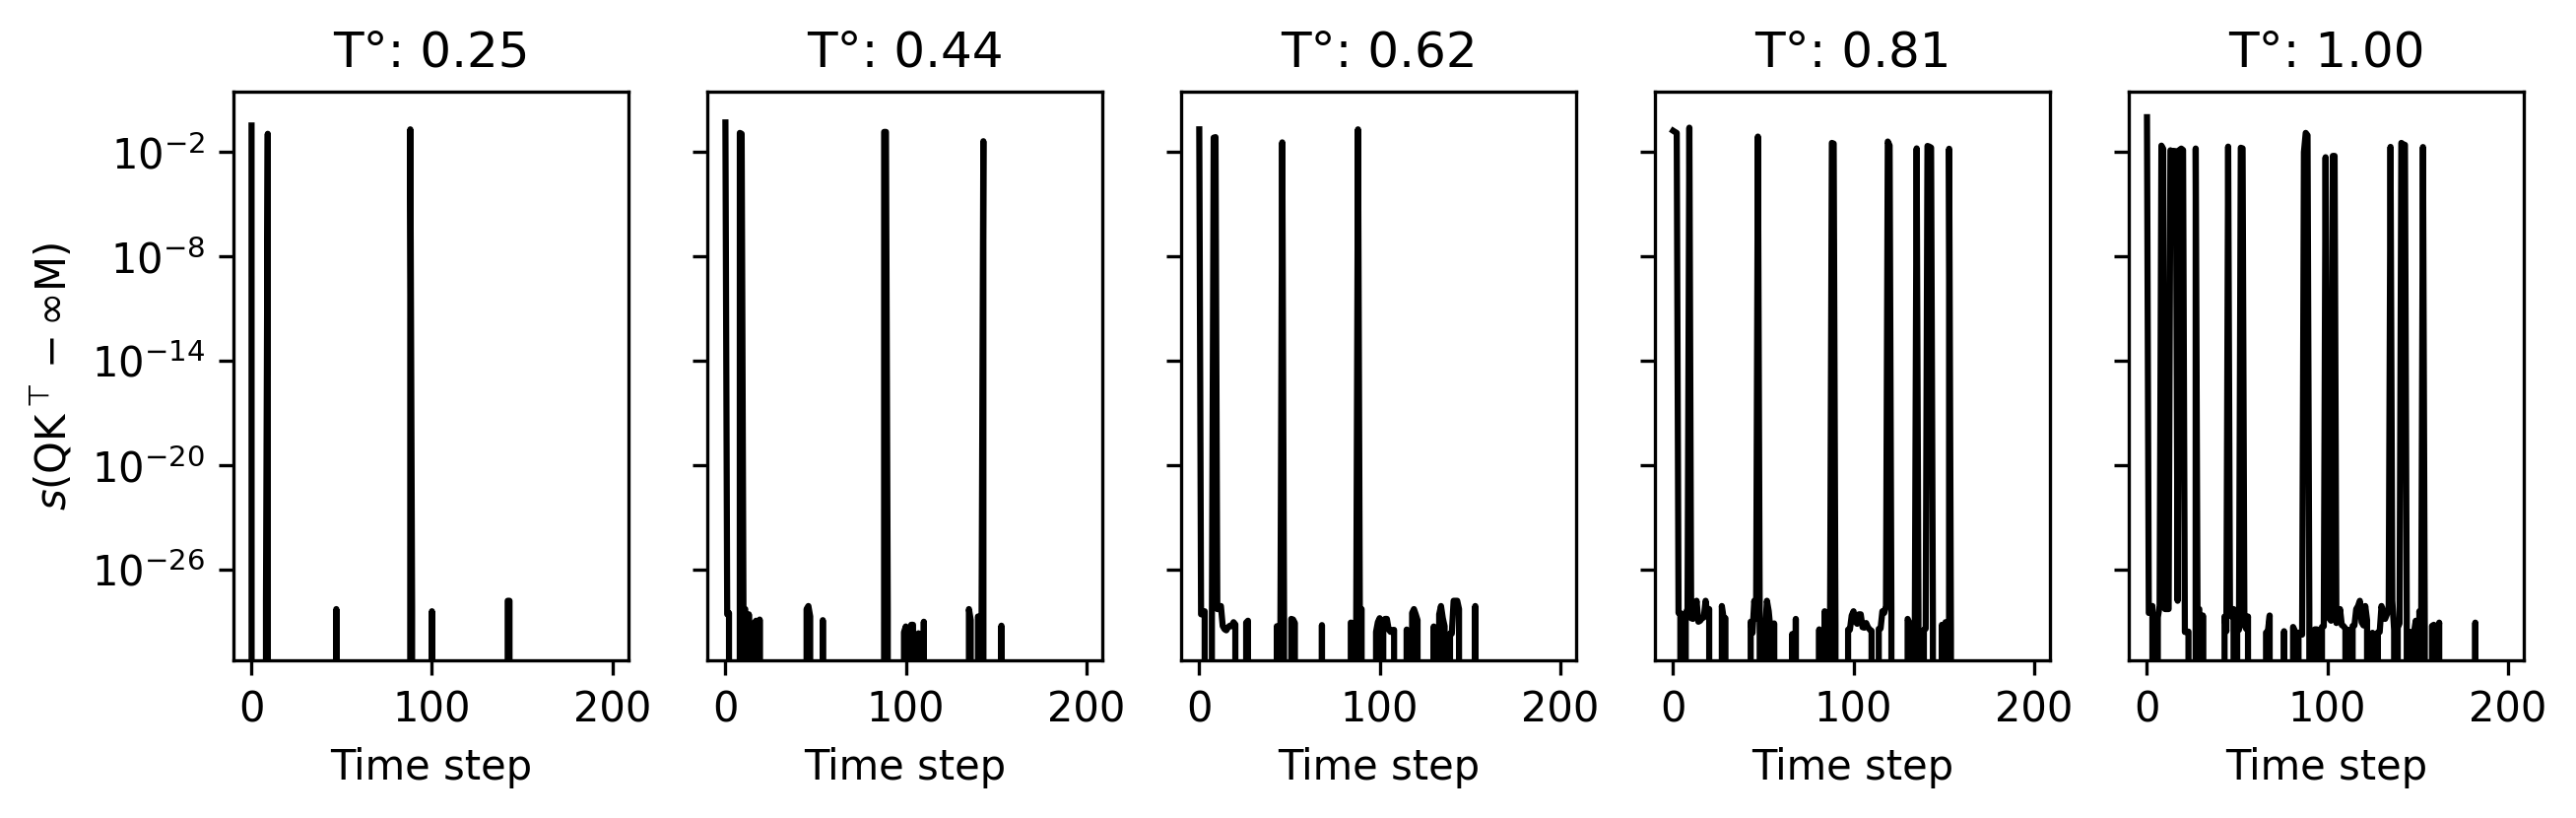

In [64]:
fig, axes = plt.subplots(1, 5, figsize=(10,2.5), sharey=True, dpi=300)

for index, av in enumerate(attention_vectors):
    axes[index].plot(av, color='k')
    axes[index].set_title('T°: {:.2f}'.format(temps[index]))
    axes[index].set_xlabel('Time step')
    axes[index].set_yscale('log')
    
axes[0].set_ylabel(r'$s(\rm{QK}^{\top} -\infty\rm{M})$')

### Effect of alpha when masking via softmax arg

In [65]:
alphas = [-1e9, -0.5, 0, 0.5, 1, 1.5]
labels = [r'$\alpha=-\inf$', r'$\alpha=-0.5$', r'$\alpha=0$', r'$\alpha=0.5$', 
          r'$\alpha=1.$', r'$\alpha=1.5$']

tf.Tensor(0.99999994, shape=(), dtype=float32)
tf.Tensor(0.99999994, shape=(), dtype=float32)
tf.Tensor(0.99999994, shape=(), dtype=float32)
tf.Tensor(0.99999994, shape=(), dtype=float32)
tf.Tensor(0.99999994, shape=(), dtype=float32)
tf.Tensor(0.99999994, shape=(), dtype=float32)


Text(0.5, 1.1, '$\\rm{W} = e^{QK + \\alpha M} \\frac{1}{\\sum e^{QK+ \\alpha M}}$')

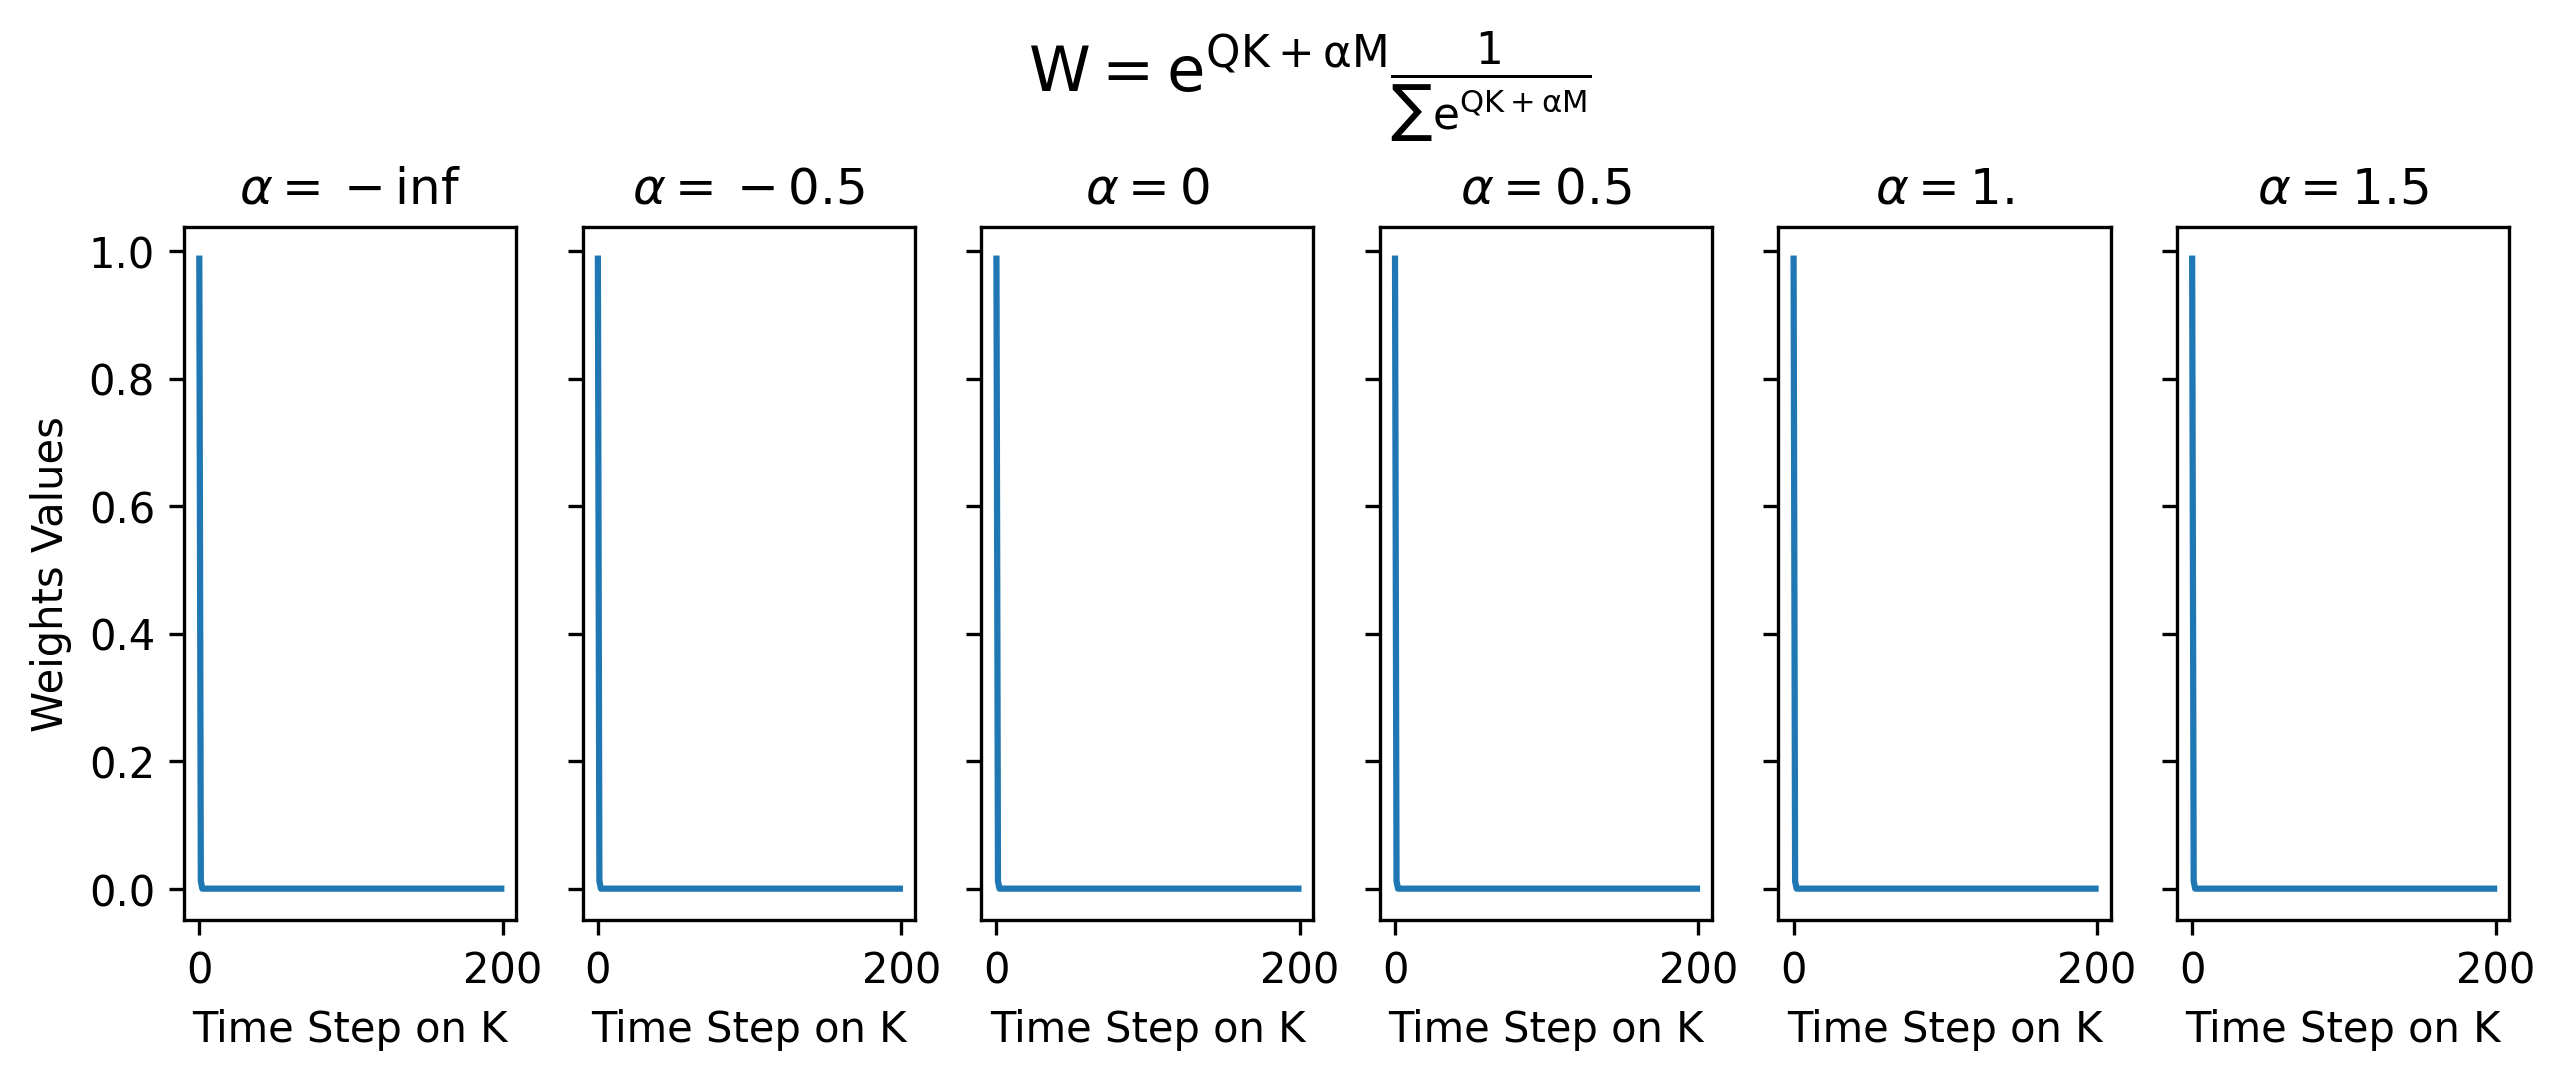

In [66]:
fig, axes = plt.subplots(1, 6, figsize=(10, 3), dpi=300, sharey=True)
axes = axes.flatten()
sim_matrices = []
for i, alp in enumerate(alphas):

    scaled_attention, attention_weights, qk_values = scaled_dot_product_attention(Q, K, V, mask=mask, m_alpha=alp)


    v = attention_weights[0, 0, 0]
    print(tf.reduce_sum(v)) 

    axes[i].plot(v)
    axes[i].set_title('{}'.format(labels[i]))
    
    axes[i].set_xlabel('Time Step on K')
    sim_matrices.append(attention_weights[0, 0])
    
axes[0].set_ylabel('Weights Values')
fig.text(0.5,1.1,r'$\rm{W} = e^{QK + \alpha M} \frac{1}{\sum e^{QK+ \alpha M}}$',horizontalalignment='center',
       verticalalignment='top', fontsize=15)

Text(0, 0.5, 'Time Step on Q')

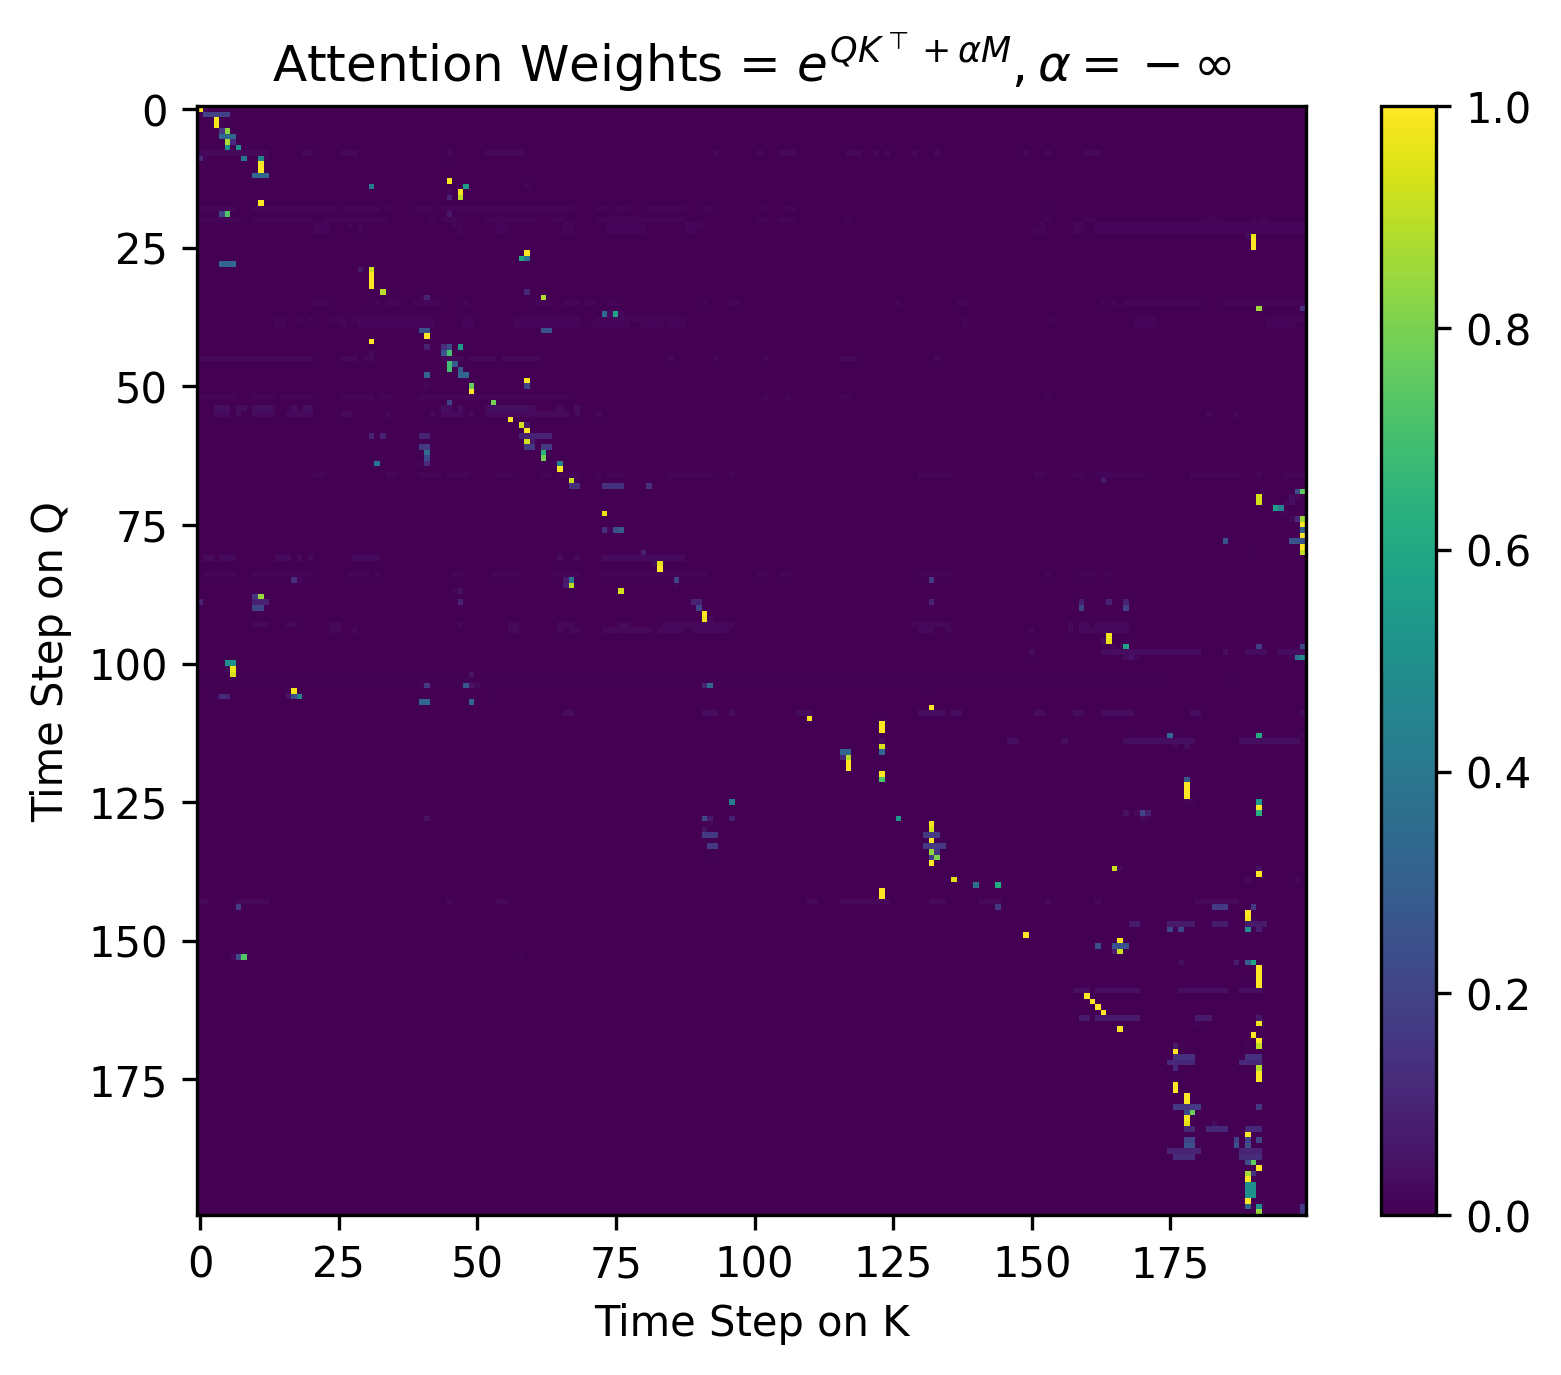

In [67]:
plt.figure(dpi=300)
plt.imshow(sim_matrices[0])
plt.title(r'Attention Weights = $e^{QK^{\top} + \alpha M}, \alpha = -\infty$')
plt.colorbar()
plt.xlabel('Time Step on K')
plt.ylabel('Time Step on Q')